# Break AES using Differential Power Analysis with correlations
## i.e. CPA = Correlation Power Analysis

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously


In [16]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Useful functions and tables

In [17]:
# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    if not txt_str[-1].strip():
        del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16), # convert from hex
                        line.rstrip().split(" ")) # each byte separated by spaces
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')

In [18]:
# read plaintext inputs
WORKING_DIR = "../../traces/test150k_pt02"
inputs = load_text(f"{WORKING_DIR}/plaintexts.txt")

# read length of one complete trace (number of samples per trace)
# with open("traceLength.txt", "r") as fin:
  # trace_length = int(fin.readline())
trace_length = 256
# trim each trace - select interesting part
tr_start = 0
tr_len = 256 # CHANGE to the length of the first round; 

# read traces from binary file -- the whole file at once, since it is quite small
traces = np.fromfile(f"{WORKING_DIR}/traces.bin", dtype='uint8') # read as linear array
traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
traces = traces[:, tr_start : tr_start + tr_len] # select only the interesting part of each trace

In [19]:
print(inputs.shape) # dimensions of inputs
print(trace_length)
print(traces.shape) # dimensions of matrix of traces

(150000, 16)
256
(150000, 256)


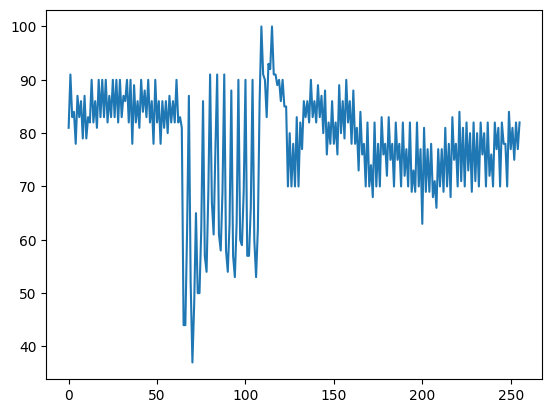

In [20]:
# Plot one trace
fig = plt.figure()
plt.plot(traces[0])
plt.show()

## **Attack the first key byte**
![Intermediate value](dpa-aes-v.png)


In [21]:
# Generate key hypotheses (all possible byte values)
keys = np.arange(start=0, stop=256, step=1, dtype='uint8')
# Select the first byte of each input block
input_byte = inputs[:, 0]
# XOR each data byte with each key (using Numpy broadcasting)
xmat = input_byte[:, np.newaxis] ^ keys

In [22]:
# Examine the inputs matrix. Does it contain the data from plaintext.txt?
print(inputs)
print(input_byte)
print(keys)
# What is the shape of all the operands from the previous cell?
print(f"{inputs.shape = }")
print(f"{input_byte.shape = }")
print(f"{input_byte[:, np.newaxis].shape = }")
print(f"{keys.shape = }")
print(f"{xmat.shape = }")
# Do you understand the values after the XOR operation? What AES operation do they represent?
print(xmat)

[[  2   0   0 ...   0   0   0]
 [121 251 106 ... 146  91 253]
 [250 154 157 ...  94 118 184]
 ...
 [ 97 151  91 ...  45  42  76]
 [ 22 156 115 ... 207 223 129]
 [ 29 246 152 ... 175 183  75]]
[  2 121 250 ...  97  22  29]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191

In [23]:
# Substitute with SBOX all XORed values -- matrix of intermediate values
smat = sbox[xmat]
print(smat)
print(smat.shape)

[[119 123  99 ...  22 176  84]
 [182 188  33 ...  95  23  68]
 [ 45  15  65 ... 197 242 107]
 ...
 [239 208 251 ... 222 219  11]
 [ 71 240 250 ... 233 155  30]
 [164 156 192 ... 225  17 152]]
(150000, 256)


In [24]:
# Compute Hamming Weights -- the matrix of hypothetical power consumption
hmat = hw_table[smat]
print(hmat)
print(hmat.shape)

[[6 6 4 ... 3 3 3]
 [5 5 2 ... 6 4 2]
 [4 4 2 ... 4 5 5]
 ...
 [7 3 7 ... 6 6 3]
 [4 4 6 ... 5 5 4]
 [3 4 2 ... 4 2 3]]
(150000, 256)


In [25]:
# Compute the correlation matrix -- correlate the hypotheses with measured traces
print(hmat.shape)
print(traces.shape)
corr = correlate(hmat, traces)
print(corr)
print(corr.shape)
# What is the shape and contents of the correlation matrix?

(150000, 256)
(150000, 256)
[[ 0.00090885  0.00170835  0.00106514 ... -0.00214975  0.0004019
   0.00015761]
 [-0.005051   -0.00667213 -0.00433367 ...  0.00407689  0.00283762
   0.00402374]
 [ 0.00355247  0.00148012  0.00342756 ... -0.00509801 -0.00430612
  -0.00624275]
 ...
 [ 0.00012727  0.00147247  0.00169868 ... -0.00266626 -0.00377137
  -0.0027924 ]
 [ 0.00186113  0.00030973  0.00097318 ...  0.00220519  0.00403983
   0.00331207]
 [-0.00338478 -0.00408642 -0.00376467 ...  0.00364303  0.00436257
   0.00560846]]
(256, 256)


In [26]:
# Find the absolute maximum correlation
acorr = abs(corr)
max_acorr = acorr.max()
(k, j) = np.where(acorr == max_acorr) # find idices of maximum
print("key: %d time: %d" % (k[0], j[0]))
print("key: %1c, %02x" % (k[0], k[0]))

key: 123 time: 65
key: {, 7b


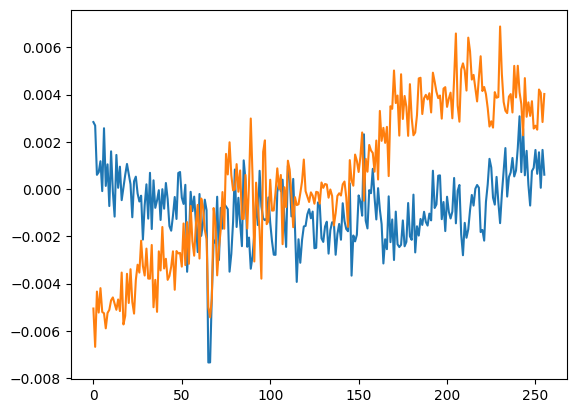

In [27]:
# Plot the correlation traces for the right key byte guess and one wrong key byte guess
# Do you see the correlation peaks?
fig = plt.figure()
plt.plot(corr[222])
plt.plot(corr[1])
plt.show()

## **Break all key bytes!**

In [28]:
keys = np.array(range(0, 256))
kk = np.zeros(16, dtype='uint8')
for i in range(0, 16):
    input_byte = inputs[:, i]
    
    xmat = input_byte[:, np.newaxis] ^ keys

    smat = sbox[xmat]

    hmat = hw_table[smat]
    
    corr = correlate(hmat, traces)

    acorr = abs(corr)
    max_acorr = acorr.max()
    (k, j) = np.where(acorr == max_acorr) # find idices of maximum
    
    kk[i] = k
    print("0x%02X @ %d" % (k[0], j[0]+tr_start))
print(f"Full key: { ' '.join([ hex(keybyte).upper() for keybyte in kk ]) }")

/tmp/ipykernel_305181/3965825542.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kk[i] = k


0x7B @ 65
0xF2 @ 65
0x9A @ 65
0x9D @ 82
0x91 @ 66
0xE9 @ 65
0x44 @ 65
0xD5 @ 66
0x26 @ 65
0xAA @ 65
0xA5 @ 65
0x9B @ 65
0x82 @ 65
0x31 @ 65
0xCE @ 65
0x45 @ 66
Full key: 0X7B 0XF2 0X9A 0X9D 0X91 0XE9 0X44 0XD5 0X26 0XAA 0XA5 0X9B 0X82 0X31 0XCE 0X45


## **Verify the key on a PT, CT pair!**

In [ ]:
key_bytes = bytes(kk)
outputs = load_text("plaintext.txt")
outputs_bytes = bytes(outputs)
ct = load_text("ciphertext.txt")
ct_bytes = bytes(ct)
print(outputs)
print(f"Key: {key_bytes.hex().upper()}")


[[  0   0   0 ...   0   0   0]
 [172 167  39 ... 200  35 205]
 [140 165  19 ...  65 161  26]
 ...
 [ 39  83 113 ... 175 134  40]
 [128 249  14 ...  98  39 161]
 [ 35 217 117 ...  33 125  20]]
Key: FDD5B41240BBA3F5F79681DFC4A00950


In [ ]:
#!pip install pycryptodome
from Crypto.Cipher import AES
cipher = AES.new(key_bytes, AES.MODE_ECB)
ciphertext = cipher.encrypt(outputs_bytes)
print(ciphertext == ct_bytes) 

ModuleNotFoundError: No module named 'Crypto'